In [2]:
df_molecules

[09/06/19 22:10:24 standardiser.standardise WARNING] Running under Windows: must disable use of timeout


# Data preparation

I have downloaded the activities from the website of Chembl25 using the following query:

<code>
(
target_chembl_id:CHEMBL206 OR 
target_chembl_id:CHEMBL242 OR 
target_chembl_id:tarCHEMBL2034 OR
target_chembl_id:CHEMBL1994 OR 
target_chembl_id:CHEMBL208 OR 
target_chembl_id:CHEMBL1871
) AND (standard_type:IC50 OR standard_type:EC50 OR standard_type:Ki OR standard_type:Kd) AND assay_type:B
    </code>

In [3]:
receptors = 'ERa,ERb,GR,MR,PR,AR'.split(',')
receptors_chembl_ids = 'CHEMBL206,CHEMBL242,CHEMBL2034,CHEMBL1994,CHEMBL208,CHEMBL1871'.split(',')
chembl_id_to_name = {a:b for a,b in zip(receptors_chembl_ids, receptors)}

In [7]:
# df_union = pd.DataFrame()
# for receptor in receptors:
#     df = pd.read_csv('primary_data/CHEMBL25-{}.csv'.format(receptor))
#     df_union = pd.concat([df_union, df])
#     del df
df_union = pd.read_csv('primary_data/CHEMBL25-all.csv')
df_union.rename(lambda x:x.replace(' ','_'), axis='columns', inplace=True)

In [8]:
df_union.head()

,Molecule,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Comment,Compound_Key,Assay,Assay_Description,BAO_Format,Target,Target_Pref._Name,Target_Organism,Target_Type,Document,Source,Max_Phase,#Ro5_Violations,Molecular_Weight,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,ALogP,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Organism_Tax_ID,BAO_Format_ID,Published_Type,Published_Relation,Published_Value,Published_Units,Canonical_Smiles,Data_Validity_Comment,Document_Journal,Document_Year,SRC_ID,UO_Units,Potential_Duplicate
0,CHEMBL225349,EC50,=,3070.0,nM,5.51,NaN,4b,CHEMBL916265,Activity at human ERalpha expressed in HAECT1 ...,cell-based format,CHEMBL206,Estrogen receptor alpha,Homo sapiens,SINGLE PROTEIN,CHEMBL1149265,Scientific Literature,0,0.0,270.29,20.40,0.38,2.67,7.02,2.84,Homo sapiens,NaN,NaN,HAECT1,NaN,9606,BAO_0000219,NaN,NaN,NaN,NaN,CCn1nc(c2ccc(O)cc2O)c3ccc(O)cc13,NaN,J. Med. Chem.,2004.0,1,UO_0000065,False
1,CHEMBL222522,IC50,=,59.0,nM,7.23,NaN,11h,CHEMBL916819,Activity at human ERalpha expressed in HAECT1 ...,cell-based format,CHEMBL206,Estrogen receptor alpha,Homo sapiens,SINGLE PROTEIN,CHEMBL1149265,Scientific Literature,0,0.0,332.32,21.75,0.41,2.31,19.00,4.92,Homo sapiens,NaN,NaN,HAECT1,NaN,9606,BAO_0000219,NaN,NaN,NaN,NaN,Cc1cc(O)ccc1c2nn(CC=C)c3c(cccc23)C(F)(F)F,NaN,J. Med. Chem.,2004.0,1,UO_0000065,False
2,CHEMBL373743,IC50,=,18.0,nM,7.75,NaN,11f,CHEMBL916819,Activity at human ERalpha expressed in HAECT1 ...,cell-based format,CHEMBL206,Estrogen receptor alpha,Homo sapiens,SINGLE PROTEIN,CHEMBL1149265,Scientific Literature,0,0.0,296.35,26.13,0.48,3.08,20.35,4.66,Homo sapiens,NaN,NaN,HAECT1,NaN,9606,BAO_0000219,NaN,NaN,NaN,NaN,Oc1ccc(cc1)c2nn(C3CCCC3)c4c(F)cccc24,NaN,J. Med. Chem.,2004.0,1,UO_0000065,False
3,CHEMBL221676,IC50,=,196.0,nM,6.71,NaN,8c,CHEMBL916819,Activity at human ERalpha expressed in HAECT1 ...,cell-based format,CHEMBL206,Estrogen receptor alpha,Homo sapiens,SINGLE PROTEIN,CHEMBL1149265,Scientific Literature,0,1.0,368.36,18.21,0.34,1.23,17.63,5.48,Homo sapiens,NaN,NaN,HAECT1,NaN,9606,BAO_0000219,NaN,NaN,NaN,NaN,Oc1ccc(cc1)c2nn(Cc3ccccc3)c4c(cccc24)C(F)(F)F,NaN,J. Med. Chem.,2004.0,1,UO_0000065,False
4,CHEMBL225022,IC50,=,112.0,nM,6.95,NaN,4e,CHEMBL916819,Activity at human ERalpha expressed in HAECT1 ...,cell-based format,CHEMBL206,Estrogen receptor alpha,Homo sapiens,SINGLE PROTEIN,CHEMBL1149265,Scientific Literature,0,0.0,298.34,23.30,0.43,3.33,8.85,3.62,Homo sapiens,NaN,NaN,HAECT1,NaN,9606,BAO_0000219,NaN,NaN,NaN,NaN,CCCCn1nc(c2ccc(O)cc2O)c3ccc(O)cc13,NaN,J. Med. Chem.,2004.0,1,UO_0000065,False


### Filter the rows with NAs

In [16]:
df_clean = df_union.query('pChEMBL_Value.notnull() and Canonical_Smiles.notnull()')
df_clean["receptor_name"] = df_clean.Target.apply(lambda x:chembl_id_to_name[x])

f:\programy\Miniconda3\envs\main\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Standardise the molecules

I use custom standardiser that combines two standardisation libraries.

It has the effect that invalid compounds get filtered out + there is some normalization.

In [17]:
df_molecules = df_clean[["Molecule", "Canonical_Smiles"]] \
    .drop_duplicates() \
    .set_index('Molecule') \
    .copy()

In [18]:
# standardise molecules and group activities by the standardised parent molecule
class CustomStandardiser:
    def __init__(self):
        self.standardiser = molvs.Standardizer()
        self.tautomer_canonicalizer = molvs.tautomer.TautomerCanonicalizer()
        self.reionzer = molvs.charge.Reionizer()

    def standardise(self, smiles):
        mol = MolFromSmiles(smiles)
        try:
            standard_parent = standardise.run(mol) # Francis Atkinson
            standard_parent2 = self.standardiser.standardize(standard_parent) # MolVS
            tautomer_parent = self.tautomer_canonicalizer.canonicalize(standard_parent2) # MolVS tautomer
            reionized_parent = self.reionzer.reionize(tautomer_parent) # MolVS reionize
            
            return reionized_parent
        except Exception as e:
            print(e)
            display(mol)
            print('---')
            return None

In [19]:
cs = CustomStandardiser()

Multiple non-salt/solvate components


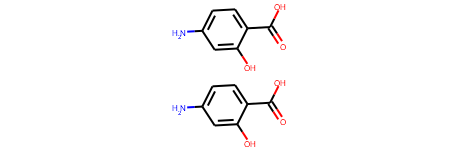

---
No non-salt/solvate components


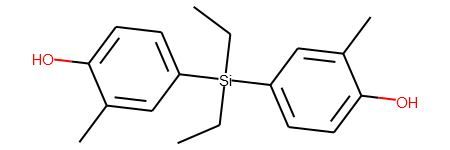

---
No non-salt/solvate components


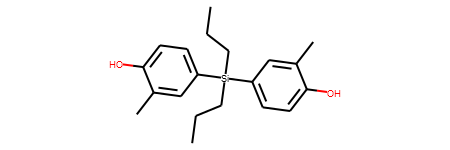

---
No non-salt/solvate components


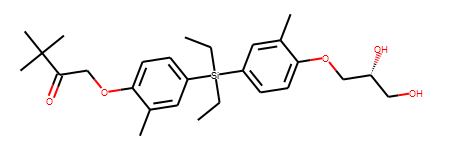

---
Multiple non-salt/solvate components


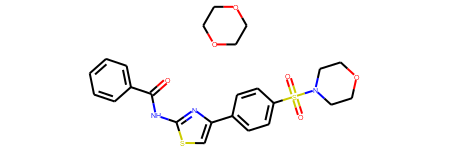

---
No non-salt/solvate components


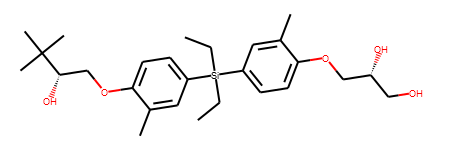

---
No non-salt/solvate components


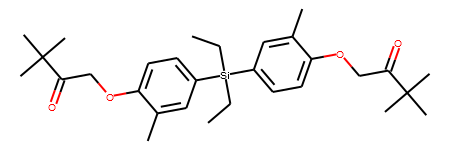

---
No non-salt/solvate components


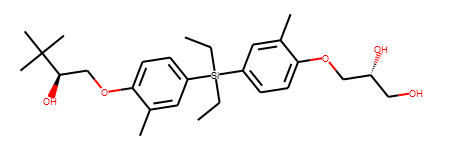

---
No non-salt/solvate components


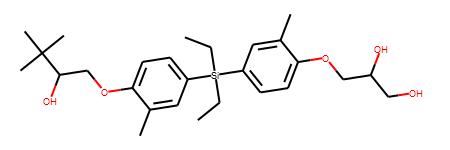

---
No non-salt/solvate components


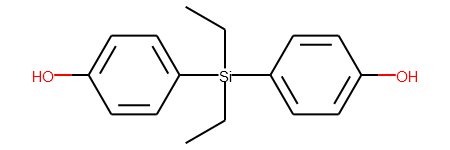

---
No non-salt/solvate components


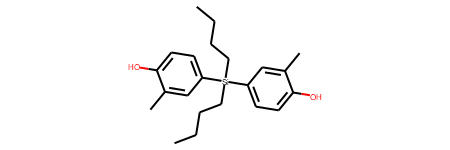

---
No non-salt/solvate components


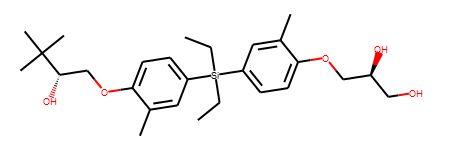

---
No non-salt/solvate components


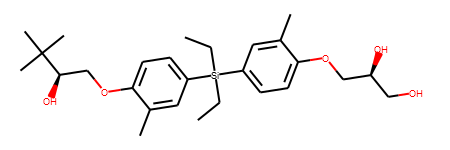

---
No non-salt/solvate components


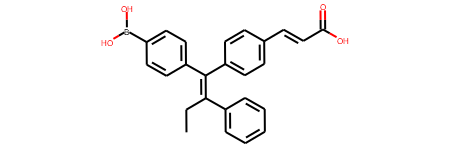

---



In [20]:
std_mols = np.asarray(list(map(cs.standardise, tqdm_notebook(df_molecules.Canonical_Smiles.values))))

In [21]:
np.save('secondary_data/std_mols.npy',std_mols)

In [22]:
std_mols = np.load('secondary_data/std_mols.npy', allow_pickle=True)

In [23]:
df_molecules['std_smiles'] = [x if x is None else MolToSmiles(x) for x in std_mols]
df_molecules['std_inchi']  = [x if x is None else MolToInchi(x) for x in std_mols]
df_molecules['std_inchi_key'] = [x if x is None else InchiToInchiKey(x) for x in df_molecules.std_inchi]

In [24]:
df_molecules_std = df_molecules[std_mols != None] \
    .drop_duplicates('std_inchi_key') \
    .set_index('std_inchi_key') \
    .drop('Canonical_Smiles', axis='columns') \
    .copy()

In [25]:
df_molecules.drop(['Canonical_Smiles','std_smiles','std_inchi'], axis='columns', inplace=True) # those columns are redundant now

In [26]:
df_molecules_std.head()

,std_smiles,std_inchi
std_inchi_key,,
FPECYZJXGMTZAF-UHFFFAOYSA-N,CCn1nc(-c2ccc(O)cc2O)c2ccc(O)cc21,InChI=1S/C15H14N2O3/c1-2-17-13-7-9(18)3-5-11(1...
SWJSHDFDYLZVEN-UHFFFAOYSA-N,C=CCn1nc(-c2ccc(O)cc2C)c2cccc(C(F)(F)F)c21,InChI=1S/C18H15F3N2O/c1-3-9-23-17-14(5-4-6-15(...
IYPUUNMLLKLEOH-UHFFFAOYSA-N,Oc1ccc(-c2nn(C3CCCC3)c3c(F)cccc23)cc1,InChI=1S/C18H17FN2O/c19-16-7-3-6-15-17(12-8-10...
DYDWLVOJCJFDBV-UHFFFAOYSA-N,Oc1ccc(-c2nn(Cc3ccccc3)c3c(C(F)(F)F)cccc23)cc1,"InChI=1S/C21H15F3N2O/c22-21(23,24)18-8-4-7-17-..."
HGZSLWUFOGHPTM-UHFFFAOYSA-N,CCCCn1nc(-c2ccc(O)cc2O)c2ccc(O)cc21,InChI=1S/C17H18N2O3/c1-2-3-8-19-15-9-11(20)4-6...


## Summarize the activities for each standardised molecule

For each pair of standardised molecule and receptor we summarize the measured values taking a median

In [42]:
df_activity = df_clean \
    .join(df_molecules, on='Molecule', how='inner') \
    .join(df_molecules_std, on='std_inchi_key', how='inner') \
    .groupby(['std_inchi_key', 'receptor_name']) \
    .aggregate('median') \
    [['Standard_Value','pChEMBL_Value']] \
    .reset_index('receptor_name') \
    .copy()

In [43]:
df_activity.head()

,receptor_name,Standard_Value,pChEMBL_Value
std_inchi_key,,,
AACVSEPXXNRBIR-UHFFFAOYSA-N,PR,16.4,7.790
AADGIVANXMJZCW-HFPMIOGFSA-N,MR,7025.0,6.075
AAJNWJFLYOFHIB-UHFFFAOYSA-N,MR,320.0,6.500
AAJNWJFLYOFHIB-UHFFFAOYSA-N,PR,140.0,6.850
AAPVCQWLJSSUGW-UHFFFAOYSA-N,AR,19000.0,4.720


## Generate fingerprints

For each molecule we generate a hashed morgan fingerprint, which is a bitstring of length 1024 and somehow encodes the structure.

In [44]:
std_mols_clean = list(map(MolFromSmiles, df_molecules_std.std_smiles))

In [45]:
df_molecules_std['std_morgan_fp'] = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024).ToBitString() for mol in std_mols_clean]

## Generate scaffolds

A scaffold is a simplified structure, where we don't differenciate between atom types and we cut-off aliphatic (non-ring) residuals

In [46]:
scaffolds = [MakeScaffoldGeneric(GetScaffoldForMol(mol)) for mol in std_mols_clean]

Molecule:


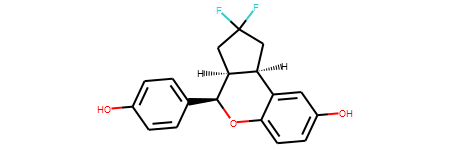

Its scaffold:


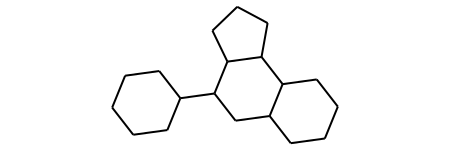

In [47]:
picked_mol = 666
print('Molecule:')
display(std_mols_clean[picked_mol])
print('Its scaffold:')
display(scaffolds[picked_mol])

In [48]:
df_molecules_std['scaffold_smiles'] = [MolToSmiles(mol) for mol in scaffolds]
df_molecules_std['scaffold_inchi'] = [MolToInchi(mol) for mol in scaffolds]
df_molecules_std['scaffold_inchi_key'] = [InchiToInchiKey(mol) for mol in df_molecules_std.scaffold_inchi]

In [49]:
df_molecules_std['scaffold_morgan_fp'] = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024).ToBitString() for mol in scaffolds]

## Export the data

In [50]:
df_clean.to_csv('secondary_data/df_clean.csv')
df_molecules_std.to_csv('secondary_data/df_molecules_std.csv')
df_activity.to_csv('secondary_data/df_activity.csv')